# Impact of the k parameter - WBCD using R



On this notebook, we present the R code to display the figure XXXXXX of the article [lien_papier].


We focus our analysis on the impact of the parameter k in the statistical structure and the security level of the dataset.


We performed two analyses:

1- Figure of projection comparison.   
2- Figure of distribution comparison accross k

If you want to look at the evolution of Auroc according to k values, open the notebook `messageC_WBCD_python.ipynb`.

In [2]:
# Main libraries
library(reticulate)
library(tidyverse)
library(reshape2)
library(mice)

# Multidimensionnal reduction method libary
library(FactoMineR)


In [4]:
colors = read.csv("../../color.csv", stringsAsFactors = FALSE)
rownames(colors) = colors$type

In [5]:
# import specific function to compute metrics 
py_run_string("import sys")
py_run_string("sys.path.append('../../lsg')")

py_run_string("from lsg.dimension.projection import Projection")

py_run_string("from lsg.security_metrics.security_metrics_class import Security_metrics ")
py_run_string("from lsg.security_metrics.record_to_avatar_distance import record_to_avatar_distance")
py_run_string("from lsg.security_metrics.local_cloaking import local_cloaking")
py_run_string("from lsg.security_metrics.avatars_are_first_hit import avatars_are_first_hit")
py_run_string("from lsg.security_metrics.hidden_rate import hidden_rate")



In [6]:
save <- FALSE

In [7]:
file_data = "../../datasets/WBCD/"
file_results = "../../figure/"

In [9]:
data <- read.csv(paste0(file_data, "breast_cancer_wisconsin.csv"), sep = ",", na.strings = c("NA", "", NA))
data <- data[,-1]

seq_k = c(4,50,100,150, 200,300)



# Projection 


We perform 2 FAMD, small k value (i.e. 1/10% of the total number of individuals) and high k value (i.e. 40/50% of the total number of individuals).

In [12]:
# Small k
k = 4 ; iter = 5
avatar_tot <- read.table(unz(paste0(file_data, "wbcd_avatarized.zip"), 
                             paste0("wbcd_avatarized/k", k, "_wbcd_avatarized.csv")), sep = ",", header = TRUE)
avatar_small<- avatar_tot[avatar_tot$iter_k == iter,]


In [13]:
# high k
k = 342 ; 
avatar_tot <- read.table(unz(paste0(file_data, "wbcd_avatarized.zip"), 
                             paste0("wbcd_avatarized/k", k, "_wbcd_avatarized.csv")), sep = ",", header = TRUE)
avatar_high <- avatar_tot[avatar_tot$iter_k == iter,]


In [18]:
# binding original, small k avatar and high k avatar datasets. 
data_small_high <- rbind(data[,1:10], avatar_small[,1:10], avatar_high[,1:10])
data_small_high$Class <- as_factor(data_small_high$Class)

row.names(data_small_high) <- 1:nrow(data_small_high)

# Perform FAMD in the priginal data space
FAMD <- FAMD(data_small_high, ncp = 5, graph = FALSE, ind.sup = (nrow(data_small_high)/3 +1):nrow(data_small_high))
res_ind <- as.data.frame(FAMD$ind.sup$coord)[1:683,]
res_ind_sup <- as.data.frame(FAMD$ind.sup$coord)[684:1366,]


## 2D projection


In [19]:
res_ind_2D = res_ind[,1:2]
res_ind_2D['type'] = 'k = 4'
res_ind_sup['type'] = 'k = 342'
res_ind_2D = rbind(res_ind_2D, res_ind_sup[, c('Dim.1', 'Dim.2', 'type')])

set.seed(42)
rows <- sample(nrow(res_ind_2D))
res_ind_2D <- res_ind_2D[rows, ]


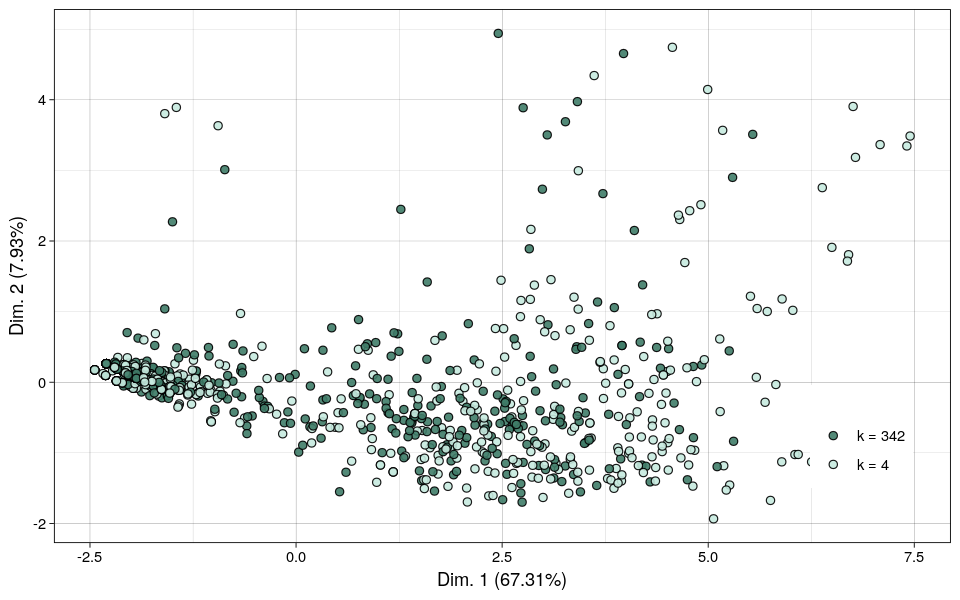

In [20]:
save = FALSE

options(repr.plot.width = 8, repr.plot.height = 5)
if (save) {tiff(paste0(file_results, "WBCD_pca2D_Ksmall_high.tiff"), res = 600, width = 14, height = 8, units = "cm")}


ggplot(res_ind_2D, aes(x=Dim.1, y=Dim.2, fill=type)) +
    geom_point(size=2, shape=21, alpha=0.9) +
    aes(fill = factor(type)) + 
    scale_fill_manual(values=c( 'k = 4' = colors["k_small", "color"],'k = 342' =  colors["k_high", "color"])) +
    xlab(paste0("Dim. 1 (", round(pca$eig[1,2], 2) ,"%)")) +
    ylab(paste0("Dim. 2 (", round(pca$eig[2,2], 2) ,"%)")) +
    labs(fill = "") +
    theme_linedraw()+
    theme(legend.position = c(0.9,0.2))


if (save) {dev.off()}

## For different k : local cloaking computation

This section provides the computation of protection metrics (local cloaking).

We first compute metrics, which need the security metrics specifique function.
Then we display the distribution of the local cloaking for different k values.

In [22]:
df_local_cloaking_k100 <- data.frame(row.names = 1:nrow(data))
hidden_rate_list = c()

pr = py$Projection()
coord_original= pr$fit_transform(data, nf = 2L)[[1]]


In [23]:
for (k in seq_k) {
    iter = 1
    avatar_tot <- read.table(unz(paste0(file_data, "wbcd_avatarized.zip"), 
                                 paste0("wbcd_avatarized/k", k, "_wbcd_avatarized.csv")), sep = ",", header = TRUE)
    avatar <- avatar_tot[avatar_tot$iter_k == iter,]
    print(dim(avatar[1:10]))
    coord_avatar = pr$transform(avatar[,1:10]) 
    
    # Local cloaking
    distances = py$record_to_avatar_distance(coord_original, coord_avatar)
    local_cloaking <- py$local_cloaking(coord_original, coord_avatar, distances)
    df_local_cloaking_k100[paste0("local_cloaking_", k)] <- local_cloaking$hit_counts[,1]
    
    # Hidden rate
    are_first_hit = py$avatars_are_first_hit (coord_original, coord_avatar, distance_metric='euclidean')
    hidden_rate = py$hidden_rate(are_first_hit)
    hidden_rate_list = c(hidden_rate_list, hidden_rate)
}

[1] 683  10
[1] 683  10
[1] 683  10
[1] 683  10
[1] 683  10
[1] 683  10


In [24]:
df_local_cloaking_k100["Class"] = data$Class
head(df_local_cloaking_k100)

local_cloaking_4,local_cloaking_50,local_cloaking_100,local_cloaking_150,local_cloaking_200,local_cloaking_300,Class
9,9,9,17,118,13,2
11,19,10,4,30,167,2
81,115,159,85,370,93,2
32,48,98,50,604,188,2
2,2,2,88,2,187,2
9,121,247,54,235,34,4


In [25]:

df_melt <- melt(df_local_cloaking_k100, id.vars = 'Class' )

hidden_rate_list = rep(hidden_rate_list, each = 683)
df_melt['hidden_rate'] = hidden_rate_list

### Violin plot 
We perform a violin plot for different k value with a log axis

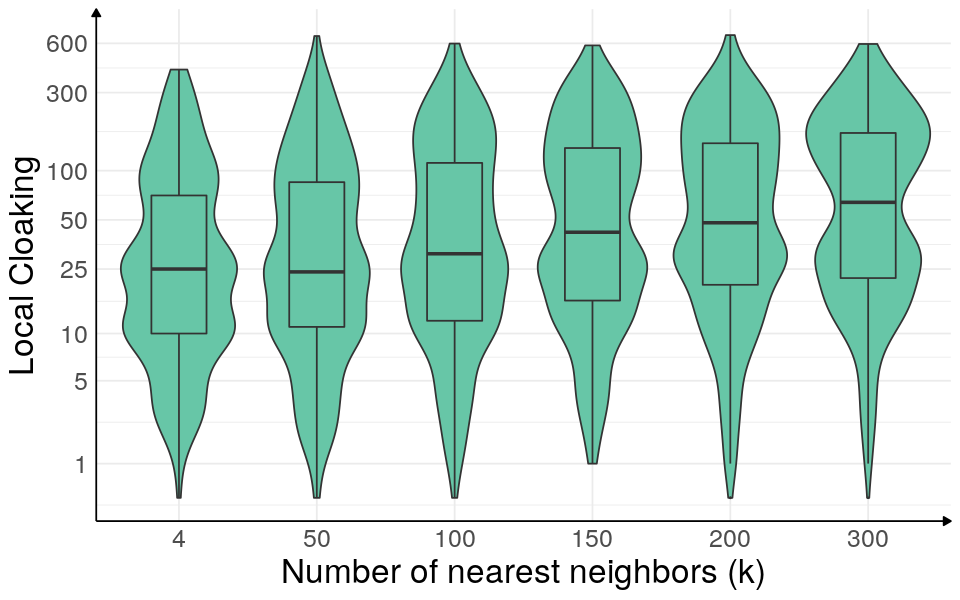

In [26]:
save = FALSE
if (save) {tiff(paste0(file_results, "WBCD_localCloaking_violinplot.tiff"), res = 600, width = 25, height = 14, units = "cm")}



ggplot(df_melt, aes(x = variable, fill = factor(Class), y =value)) + 
    geom_violin(trim=TRUE, fill = colors['avatar', 'color'])+
    geom_boxplot(width=0.4, fill = colors['avatar', 'color'], outlier.size = 0.1) +
    scale_x_discrete(labels = as.character(seq_k)) +
    scale_y_continuous(trans=scales::pseudo_log_trans(base = 10), breaks = c(1,5,10,25,50,100,300, 600)) +
    xlab("Number of nearest neighbors (k)") +
    ylab("Local Cloaking") +
    theme_minimal() +  
    theme(legend.position = "right",
          axis.title.y = element_text(angle = 90, vjust = 1, size = 20),
          axis.text=element_text(size=15), 
          axis.title.x = element_text(size = 20),
          axis.line = element_line(colour = "black", 
                      size = 0.5, linetype = "solid", arrow = arrow(type='closed', length = unit(5,'pt'))))+ 
    coord_cartesian(ylim = c(0, 700))

if (save) {dev.off()}

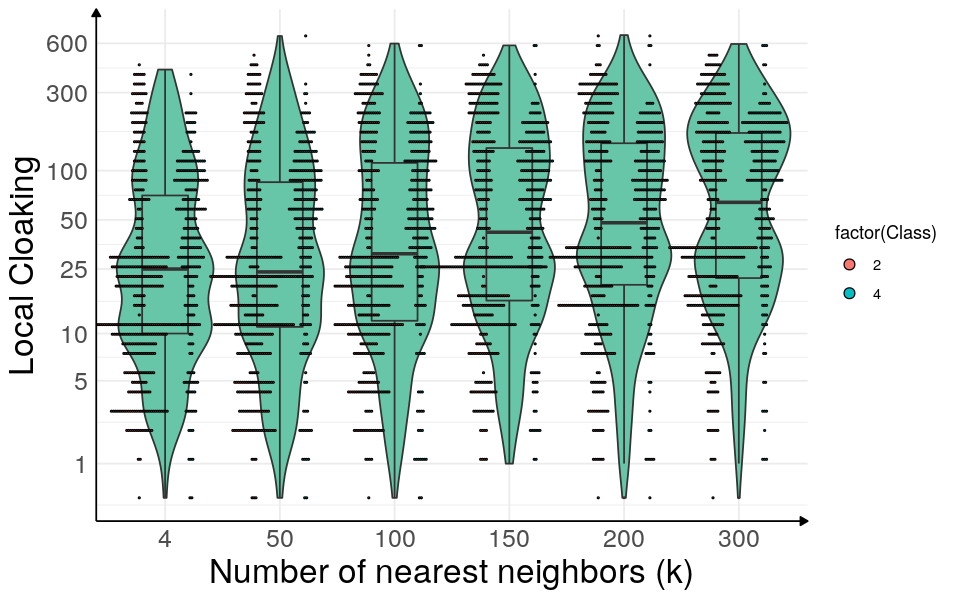

In [27]:

ggplot(df_melt, aes(x = variable, fill = factor(Class), y =value)) + 
    geom_violin(trim=TRUE, fill = colors['avatar', 'color'])+
    geom_boxplot(width=0.4, fill = colors['avatar', 'color'], outlier.size = 0.1) +
    scale_x_discrete(labels = as.character(seq_k)) +
    scale_y_continuous(trans=scales::pseudo_log_trans(base = 10), breaks = c(1,5,10,25,50,100,300, 600)) +
    geom_dotplot(binaxis= "y",
                 stackdir = "center", position = "dodge",
                 dotsize = 0.2, 
                 method = 'histodot',
                 binwidth = 1/17
                 
                )+
    xlab("Number of nearest neighbors (k)") +
    ylab("Local Cloaking") +
    theme_minimal() +  
    theme(legend.position = "right",
          axis.title.y = element_text(angle = 90, vjust = 1, size = 20),
          axis.text=element_text(size=15), 
          axis.title.x = element_text(size = 20),
          axis.line = element_line(colour = "black", 
                      size = 0.5, linetype = "solid", arrow = arrow(type='closed', length = unit(5,'pt'))))+ 
    coord_cartesian(ylim = c(0, 700))

